#### Imports

In [1]:
import numpy as np
import pandas as pd

import pickle
from scipy.io import loadmat
import yaml

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

# import scipy

# Load data, create data structures and pre-processing

## Fixations

#### Read CSVs as DataFrame

In [2]:
df_all = pd.read_csv('../data/data_all.csv', index_col='index')
df_first = pd.read_csv('../data/data_firstfixation.csv', index_col='index')

## Salience mass

#### Read CSVs as DataFrame

In [3]:
df_mass = pd.read_csv('../data/salience_mass_trials.csv', index_col='index')

#### Normalize salience mass

In [4]:
mass_total_gbvs = df_mass.gbvs_left + df_mass.gbvs_right
mass_total_deepgaze = df_mass.deepgaze_left + df_mass.deepgaze_right

df_mass.gbvs_left = df_mass.gbvs_left / mass_total_gbvs
df_mass.gbvs_right = df_mass.gbvs_right / mass_total_gbvs

df_mass.deepgaze_left = df_mass.deepgaze_left / mass_total_deepgaze
df_mass.deepgaze_right = df_mass.deepgaze_right / mass_total_deepgaze

#### Add deltas

In [5]:
df_mass['mass_delta_gbvs'] = df_mass['gbvs_left'] - df_mass['gbvs_right']
df_mass['mass_delta_deepgaze'] = df_mass['deepgaze_left'] - df_mass['deepgaze_right']

#### Add salience mass to df_first

In [6]:
df_first = df_first.merge(df_mass, left_on='idx_trial_subj', right_on='idx_trial_subj')

### Dwell time

#### Read CSVs as DataFrame

In [7]:
df_time = pd.read_csv('../data/data_time.csv', index_col='index')

#### Add dwell time to df_first

In [8]:
columns_diff = df_time.columns.difference(df_first.columns)
columns_diff = columns_diff.insert(0, 'idx_trial_subj')
df_first = df_first.merge(right=df_time[columns_diff], how='left', left_on='idx_trial_subj', 
                          right_on='idx_trial_subj')

## Image categories

#### Read categories as a dictionary

In [9]:
categories_dict = yaml.load(open('../data/categories.yml', 'r'), Loader=yaml.FullLoader)

In [10]:
df_categories = pd.DataFrame(columns=['image', 'category'])

idx = 0
for k, v in categories_dict.items():
    if k == 'ambiguous':
        continue
    else:
        d = pd.DataFrame({'image': v, 
                          'category': k},
                         index=np.arange(idx, idx + len(v)).tolist())
        idx = idx + len(v)
        df_categories = df_categories.append(d)

## Coefficients from the trained model
The global salience scores and the lateral, task and familiarity coefficients

In [11]:
df_coeff = pd.read_csv('../data/coefficients_100runs.csv', index_col='index')

zscores = df_coeff.filter(regex='zscores_*')
subject_bias = df_coeff.filter(regex='subject_*')
task_coeff = df_coeff.task
familiarity_coeff = df_coeff.familiarity

zscores_mean = zscores.mean(axis=0)
zscores_std = zscores.std(axis=0)

#### Add global salience scores to df_first

In [12]:
d_scores_left = {'image_left': [int(s.split('_')[-1]) for s in zscores_mean.index],
                 'global_salience_left': zscores_mean.values}
df_scores_left = pd.DataFrame(d_scores_left)

d_scores_right = {'image_right': [int(s.split('_')[-1]) for s in zscores_mean.index],
                  'global_salience_right': zscores_mean.values}
df_scores_right = pd.DataFrame(d_scores_right)

In [13]:
df_first = df_first.merge(df_scores_left, left_on='image_left', right_on='image_left')
df_first = df_first.merge(df_scores_right, left_on='image_right', right_on='image_right')
df_first['global_salience_delta'] = df_first['global_salience_left'] - df_first['global_salience_right']

## Kullback-Leibler divergence (KLD)

The KLD between visual salience distribution and first fixation distribution (computed elsewhere in MATLAB)

In [14]:
kld_gbvs = loadmat('../data/kld_gbvs.mat')
kld_deepgaze = loadmat('../data/kld_deepgaze.mat')

# Plot settings

In [15]:
sns.set(style="whitegrid")
fontsize = 15

## Colour palettes

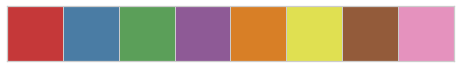

In [16]:
sns.palplot(sns.color_palette('Set1', n_colors=8, desat=.7))

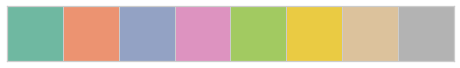

In [17]:
sns.palplot(sns.color_palette('Set2', n_colors=8, desat=.8))

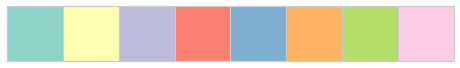

In [18]:
sns.palplot(sns.color_palette('Set3', n_colors=8))

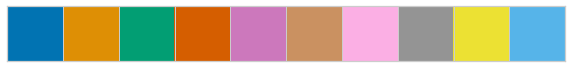

In [19]:
sns.palplot(sns.color_palette('colorblind'))

### Image categories

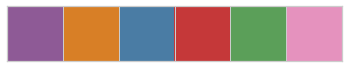

In [20]:
color_faces = sns.color_palette('Set1', n_colors=8, desat=.7)[3]
color_humans = sns.color_palette('Set1', n_colors=8, desat=.7)[4]
color_urban = sns.color_palette('Set1', n_colors=8, desat=.7)[1]
color_indoor = sns.color_palette('Set1', n_colors=8, desat=.7)[0]
color_natural = sns.color_palette('Set1', n_colors=8, desat=.7)[2]
color_noise = sns.color_palette('Set1', n_colors=8, desat=.7)[7]
categories_palette = [color_faces, color_humans, color_urban, color_indoor, color_natural, color_noise]
categories_order = ['faces', 'humans', 'urban', 'indoor', 'natural', 'noise']
sns.palplot(categories_palette)

### Left - Right

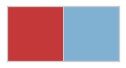

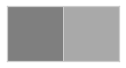

In [21]:
color_right = sns.color_palette('Set3', n_colors=8, desat=1.)[4]
color_left = sns.color_palette('Set1', n_colors=8, desat=.7)[0]
lr_palette = [color_left, color_right]
lr_palette_bnw = [sns.desaturate(color_left, 0.), sns.desaturate(color_right, 0.)]
sns.palplot(lr_palette)
sns.palplot(lr_palette_bnw)

### Select new - Select old

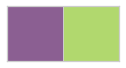

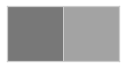

In [22]:
color_selnew = sns.color_palette('Set1', n_colors=8, desat=.6)[3]
color_selold = sns.color_palette('Set3', n_colors=8, desat=.9)[6]
sel_palette = [color_selnew, color_selold]
sel_palette_bnw = [sns.desaturate(color_selnew, 0.), sns.desaturate(color_selold, 0.)]
sns.palplot(sel_palette)
sns.palplot(sel_palette_bnw)

### Scatter

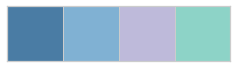

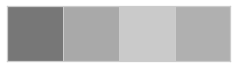

In [23]:
color_scatter_main = sns.color_palette('Set1', n_colors=8, desat=.7)[1]
color_scatter2 = sns.color_palette('Set3', n_colors=8)[4]
color_scatter3 = sns.color_palette('Set3', n_colors=8)[2]
color_scatter4 = sns.color_palette('Set3', n_colors=8)[0]
colors_scatter = [color_scatter_main, color_scatter2, color_scatter3, color_scatter4]
colors_scatter_bnw = [sns.desaturate(color_scatter_main, 0.), sns.desaturate(color_scatter2, 0.), 
                      sns.desaturate(color_scatter3, 0.), sns.desaturate(color_scatter4, 0.)]
sns.palplot(colors_scatter)
sns.palplot(colors_scatter_bnw)

# Plots

## Global salience per category

#### Create data frame

In [ ]:
columns = ['category', 'salience', 'image']
df_globsal_cat = pd.DataFrame(columns=columns)

idx = 0
for image in df_first.image_left.unique():
    
    globsal_left =  np.asarray(df_first.loc[df_first.image_left == image]['global_salience_left'])
    globsal_right =  np.asarray(df_first.loc[df_first.image_right == image]['global_salience_right'])
    globsal_all = np.concatenate((globsal_left, globsal_right))
    globsal = globsal_all[0]
    for globsal_el in globsal_all:
        if globsal_el != globsal:
            print('Error!')
            
    category_left =  np.asarray(df_first.loc[df_first.image_left == image]['category_left'])
    category_right =  np.asarray(df_first.loc[df_first.image_right == image]['category_right'])
    category_all = np.concatenate((category_left, category_right))
    category = category_all[0]
    for category_el in category_all:
        if category_el != category:
            print('Error!')
    
    d = pd.DataFrame({'category': category, 
                      'salience': globsal,
                      'image': image},
                      index=[idx])
    df_globsal_cat = df_globsal_cat.append(d)
    idx += 1

#### Plot

In [ ]:
do_save = False

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(14, 5))

sns.swarmplot(data=df_globsal_cat,
              x='salience', 
              y='category',
              order=['faces', 'humans', 'urban', 'indoor', 'natural', 'noise'],
              palette=categories_palette,
              size=8.);

# Change Y-Tick labels
ax.set_yticklabels(['Faces', 'Humans', 'Urban', 'Indoor', 'Natural', 'Noise'], 
                   fontsize=fontsize);

# Remove Y-label
ax.set_ylabel(ylabel='');

# Change X-Tick labels
xlim = [-3., 2.1]
xticks = np.arange(xlim[0], xlim[1], 0.5);
ax.set(xticks=xticks);
plt.setp(ax.get_xticklabels(), fontsize=fontsize);

# Set X-label
ax.set_xlabel(xlabel='Global Salience',
              fontsize=fontsize);

# Change spines
sns.despine(left=True, bottom=True)

# Save figure
if do_save:
    plt.tight_layout()
    plt.savefig('global_salience.png', dpi=f.dpi * 3, bbox_inches='tight')

## Left/right per blocks and subjects

#### Create data frame

In [ ]:
columns = ['pct_left', 'total', 'block', 'subject']
df_lr_blocks = pd.DataFrame(columns=columns)

idx = 0
for block in np.unique(df_first['block']):
    for subject in np.unique(df_first['subject_index']):
        df_block_subj = df_first.loc[(df_first.block == block) & (df_first.subject_index == subject)]
        n_left = np.sum(df_block_subj['is_left'])
        n_right = np.sum(df_block_subj['is_right'])
        if n_left + n_right != len(df_block_subj):
            print('Error: left + right != total')
        else:
            d = pd.DataFrame({'block': block, 
                              'subject': subject,
                              'pct_left': np.divide(float(n_left), len(df_block_subj)),
                              'total': 1.0},
                              index=[idx])
            df_lr_blocks = df_lr_blocks.append(d)
            idx += 1

#### Plot

In [ ]:
do_save = False

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(14, 3))

# Plot the total (right)
sns.barplot(data=df_lr_blocks,
            x='total', y='block',
            orient='h', 
            label='right', color=color_right, ci=None)

# Plot the left
sns.barplot(data=df_lr_blocks,
            x='pct_left', y='block', 
            orient='h', 
            label='left', color=color_left,
            errcolor='black', errwidth=1.5, capsize=.1)

# Draw line at 0.5
y = np.arange(ax.get_ylim()[1]+0.1, ax.get_ylim()[0], 0.1)
x = 0.5 * np.ones(y.shape[0])
ax.plot(x, y, linestyle=':', linewidth=1.5, color='black')

# Change Y-Tick labels
yticklabels = ['Block {}'.format(ytick.get_text()) for ytick in ax.get_yticklabels()]
ax.set_yticklabels(yticklabels, 
                   fontsize=fontsize);

# Remove Y-label
ax.set_ylabel(ylabel='');

# Change X-Tick labels
xlim = [0., 1.1]
xticks = np.arange(xlim[0], xlim[1], 0.1);
ax.set(xticks=xticks);
plt.setp(ax.get_xticklabels(), fontsize=fontsize);

# Set X-label
ax.set_xlabel(xlabel='Percentage of first saccades to the left | right',
              y=-5.,
              visible=True,
              fontsize=fontsize);

# Change spines
sns.despine(left=True, bottom=True)

# Save figure
if do_save:
    plt.tight_layout()
    plt.savefig('first_saccade_blocks.png', dpi=f.dpi * 3, bbox_inches='tight')

## New/old per task

#### Create data frame

In [ ]:
dict_newold = {2: 'new image', 3: 'old image'}
columns = ['pct_new', 'total', 'task']
df_newold_task = pd.DataFrame(columns=columns)

idx = 0
for block in np.unique(df_first['block']):
    if (block == 1) | (block == 4):
        continue
    for subject in np.unique(df_first['subject_index']):
        df_block_subj = df_first.loc[(df_first.block == block) & (df_first.subject_index == subject)]
        n_new = len(df_block_subj.loc[(df_block_subj.is_left) & (df_block_subj.left_is_new)]) + \
                len(df_block_subj.loc[(df_block_subj.is_right) & (df_block_subj.right_is_new)])
        n_old = len(df_block_subj.loc[(df_block_subj.is_left) & (df_block_subj.right_is_new)]) + \
                len(df_block_subj.loc[(df_block_subj.is_right) & (df_block_subj.left_is_new)])
        if n_new + n_old != len(df_block_subj):
            print('Error: new ({}) + old ({}) != total ({}) - Subject {} Block {}'.format(
                n_new, n_old, len(df_block_subj), subject, block))
        else:
            d = pd.DataFrame({'task': dict_newold[block], 
                              'subject': subject,
                              'pct_new': np.divide(float(n_new), len(df_block_subj)),
                              'total': 1.0},
                              index=[idx])
            df_newold_task = df_newold_task.append(d)
            idx += 1

#### Plot

In [ ]:
do_save = False

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(14, 2))

# Plot the total (right)
sns.barplot(data=df_newold_task,
            x='total', y='task', 
            label='old', color=color_selold)

# Plot the left
sns.barplot(data=df_newold_task,
            x='pct_new', y='task', 
            label='new', color=color_selnew,
            errcolor='black', errwidth=1.5, capsize=.1)

# Draw line at 0.5
y = np.arange(ax.get_ylim()[1]+0.1, ax.get_ylim()[0], 0.1)
x = 0.5 * np.ones(y.shape[0])
ax.plot(x, y, linestyle=':', linewidth=1.5, color='black')

# Change Y-Tick labels
ax.set_yticklabels(['Select\nnew image', 'Select\nold image'], 
                   fontsize=fontsize);

# Remove Y-label
ax.set_ylabel(ylabel='');

# Change X-Tick labels
xlim = [0., 1.1]
xticks = np.arange(xlim[0], xlim[1], 0.1);
ax.set(xticks=xticks);
plt.setp(ax.get_xticklabels(), fontsize=fontsize);

# Set X-label
ax.set_xlabel(xlabel='Percentage of first saccades on the new | old image',
              y=-5.,
              visible=True,
              fontsize=fontsize);

# Change spines
sns.despine(left=True, bottom=True)

# Save figure
if do_save:
    plt.tight_layout()
    plt.savefig('first_saccade_tasks.png', dpi=f.dpi * 3, bbox_inches='tight')

## Dwell time per blocks and subjects

#### Plot

In [ ]:
do_save = False

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(14, 3))

# Plot the total (right)
sns.barplot(x=np.ones(len(df_first), dtype=float), y='block', orient='h', data=df_first,
            label='right', color=color_right, ci=None)

# Plot the left
sns.barplot(x='time_left', y='block', orient='h', data=df_first,
            label='left', color=color_left,
            errcolor='black', errwidth=1.5, capsize=.1)

# Draw line at 0.5
y = np.arange(ax.get_ylim()[1]+0.1, ax.get_ylim()[0], 0.1)
x = 0.5 * np.ones(y.shape[0])
ax.plot(x, y, linestyle=':', linewidth=1.5, color='black')

# Change Y-Tick labels
yticklabels = ['Block {}'.format(ytick.get_text()) for ytick in ax.get_yticklabels()]
ax.set_yticklabels(yticklabels, 
                   fontsize=fontsize);

# Remove Y-label
ax.set_ylabel(ylabel='');

# Change X-Tick labels
xlim = [0., 1.1]
xticks = np.arange(xlim[0], xlim[1], 0.1);
ax.set(xticks=xticks);
plt.setp(ax.get_xticklabels(), fontsize=fontsize);

# Set X-label
ax.set_xlabel(xlabel='Relative dwell time on the image on the left | right',
              y=-5.,
              visible=True,
              fontsize=fontsize);

# Change spines
sns.despine(left=True, bottom=True)

# Save figure
if do_save:
    plt.tight_layout()
    plt.savefig('dwell_blocks.png', dpi=f.dpi * 3, bbox_inches='tight')

## Dwell time on new/old per task

#### Create data frame

In [ ]:
df_first_sel = df_first.loc[(df_first.block == 2) | (df_first.block == 3)]

#### Plot

In [ ]:
do_save = False

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(14, 2))

# Plot the total (right)
sns.barplot(x=np.ones(len(df_first_sel), dtype=float), y='block', orient='h', data=df_first_sel,
            label='right', color=color_selold, ci=None)

# Plot the left
sns.barplot(x='time_left', y='block', orient='h', data=df_first_sel.loc[df_first_sel.new_image == True],
            label='left', color=color_selnew,
            errcolor='black', errwidth=1.5, capsize=.1)

# Draw line at 0.5
y = np.arange(ax.get_ylim()[1]+0.1, ax.get_ylim()[0], 0.1)
x = 0.5 * np.ones(y.shape[0])
ax.plot(x, y, linestyle=':', linewidth=1.5, color='black')

# Change Y-Tick labels
yticklabels = ['Select\nnew image', 'Select\nold image']
ax.set_yticklabels(yticklabels, 
                   fontsize=fontsize);

# Remove Y-label
ax.set_ylabel(ylabel='');

# Change X-Tick labels
xlim = [0., 1.1]
xticks = np.arange(xlim[0], xlim[1], 0.1);
ax.set(xticks=xticks);
plt.setp(ax.get_xticklabels(), fontsize=fontsize);

# Set X-label
ax.set_xlabel(xlabel='Relative dwell time on the new | old image',
              y=-5.,
              visible=True,
              fontsize=fontsize);

# Change spines
sns.despine(left=True, bottom=True)

# Save figure
if do_save:
    plt.tight_layout()
    plt.savefig('dwell_fam_task.png', dpi=f.dpi * 3, bbox_inches='tight')

## Dwell time vs. global salience

#### Create data frame
Average the dwell time of each image over all the trials

In [ ]:
columns = ['image', 'dwell_time', 'global_salience']
df_scores = pd.DataFrame(columns=columns)

idx = 0
for image in sorted(df_first.image_left.unique()):
    dwt_left = df_first.loc[df_first.image_left == image].time_left
    dwt_right = df_first.loc[df_first.image_right == image].time_right
    dwell_time = np.mean(np.concatenate((dwt_left, dwt_right), axis=0))
    
    global_salience_left = np.asarray(df_first.loc[df_first.image_left == image]['global_salience_left'])
    global_salience_right = np.asarray(df_first.loc[df_first.image_right == image]['global_salience_right'])
    global_salience = np.concatenate((global_salience_left, global_salience_right))
    global_salience_val = global_salience[0]
    for global_salience_el in global_salience:
        if global_salience_el != global_salience_val:
            print('Error!')    
        
    d = pd.DataFrame({'image': image, 
                      'dwell_time': dwell_time,
                      'global_salience': global_salience_val},
                      index=[idx])
    idx += 1
    df_scores = df_scores.append(d)

#### Add categories

In [ ]:
df_scores = df_scores.merge(df_categories, left_on='image', right_on='image')

#### Plot - no colors categories

In [ ]:
do_save = False

# Initialize the matplotlib figure
f, ax = plt.subplots()

sns.regplot(x='global_salience', 
            y='dwell_time', 
            data=df_scores,
            color=colors_scatter[0]);

# Change Y-Tick labels
plt.setp(ax.get_yticklabels(), fontsize=fontsize*0.8);

# Set Y-label
ax.set_ylabel(ylabel='Relative dwell time [s]', fontsize=fontsize);

# Change X-Tick labels
xlim = [-3.0, ax.get_xlim()[1]]
ax.set_xlim(xlim)
xticks = np.arange(xlim[0], xlim[1], 0.5);
ax.set(xticks=xticks);
plt.setp(ax.get_xticklabels(), fontsize=fontsize*0.8);


# Set X-label
ax.set_xlabel(xlabel='Global image salience scores',
              fontsize=fontsize);

# Change spines
# sns.despine(left=True, bottom=True, right=True)

# Annotate correlation coefficient
pearsonr = np.corrcoef(df_scores.dwell_time, df_scores.global_salience)[0, 1]
ax.annotate('Pearson $r = {:.2f}$'.format(pearsonr), xy=(-2.75, 0.63), fontsize=fontsize)

# Save figure
if do_save:
    plt.tight_layout()
    plt.savefig('dwell_scores.png', dpi=f.dpi * 3, bbox_inches='tight')

#### Plot - colors categories

In [ ]:
do_save = False

# Initialize the matplotlib figure
# f, ax = plt.subplots(figsize=(8, 8))
f, ax = plt.subplots()

# Adjust axes limits
ylim = [0.1, 0.8]
ax.set_ylim(ylim)
xlim = [-3., 2.25]
ax.set_xlim(xlim)

sns.regplot(x='global_salience', 
            y='dwell_time', 
            data=df_scores,
            color=colors_scatter[0],
            scatter=False,
            truncate=False);
sns.scatterplot(x='global_salience', 
                y='dwell_time', 
                data=df_scores,
                hue='category',
                hue_order=categories_order,
                palette=categories_palette,
                legend=False);

# Change Y-Tick labels
plt.setp(ax.get_yticklabels(), fontsize=fontsize*0.8);

# Set Y-label
ax.set_ylabel(ylabel='Relative dwell time [s]', fontsize=fontsize);

# Change X-Tick labels
xticks = np.arange(xlim[0], xlim[1], 0.5);
ax.set(xticks=xticks);
plt.setp(ax.get_xticklabels(), fontsize=fontsize*0.8);


# Set X-label
ax.set_xlabel(xlabel='Global image salience scores',
              fontsize=fontsize);

# Change spines
# sns.despine(left=True, bottom=True, right=True)

# Annotate correlation coefficient
pearsonr = np.corrcoef(df_scores.dwell_time, df_scores.global_salience)[0, 1]
ax.annotate('Pearson $r = {:.2f}$'.format(pearsonr), xy=(-2.75, 0.63), fontsize=fontsize)

# Save figure
if do_save:
    plt.tight_layout()
    plt.savefig('dwell_scores.png', dpi=f.dpi * 3, bbox_inches='tight')

In [ ]:
# pearsonr, pval = scipy.stats.pearsonr(df_scores.dwell_time, df_scores.global_salience)
# print(pearsonr, pval)

## Frequency of first saccades vs. subject bias

#### Create data frame

In [ ]:
columns = ['subject_index', 'pct_right', 'std_right', 'mean_subject_bias']
subject_bias_df = pd.DataFrame(columns=columns)

idx = 0
for subject_index in df_first.subject_index.unique():
    
    n_right = np.sum(df_first.loc[df_first.subject_index == subject_index].is_right)
    n_total = len(df_first.loc[df_first.subject_index == subject_index])
    pct_right = float(n_right) / n_total
            
    d = pd.DataFrame({'subject_index': subject_index, 
                      'pct_right': pct_right,
                      'mean_subject_bias': subject_bias['subject_{:d}'.format(subject_index)].mean()},
                      index=[idx])
    idx += 1
    subject_bias_df = subject_bias_df.append(d)

#### Plot

In [ ]:
do_save = False

# Initialize the matplotlib figure
f, ax = plt.subplots()

sns.regplot(data=subject_bias_df,
            x='pct_right', 
            y='mean_subject_bias',
            color=colors_scatter[0]);

# Change Y-Tick labels
ylim = [-6., ax.get_ylim()[1]]
ax.set_ylim(ylim)
plt.setp(ax.get_yticklabels(), fontsize=fontsize*0.8);

# Set Y-label
ax.set_ylabel(ylabel='Lateral bias coefficient\nlearned by the model', fontsize=fontsize);

# Change X-Tick labels
xlim = [ax.get_xlim()[0], 0.8]
ax.set_xlim(xlim)
plt.setp(ax.get_xticklabels(), fontsize=fontsize*0.8);

# Set X-label
ax.set_xlabel(xlabel='Percentage of first fixations on the right image',
              fontsize=fontsize);

# Annotate correlation coefficient
pearsonr = np.corrcoef(subject_bias_df.pct_right, subject_bias_df.mean_subject_bias)[0, 1]
ax.annotate('Pearson $r = {:.2f}$'.format(pearsonr), xy=(0.03, 2.20), fontsize=fontsize)

# Save figure
if do_save:
    plt.tight_layout()
    plt.savefig('subject_bias.png', dpi=f.dpi * 3, bbox_inches='tight')

## Delta mass vs. delta global scores

#### Create data frames

In [ ]:
df_noise_left = df_first.loc[df_first.category_left == 'noise']
df_noise_right = df_first.loc[df_first.category_right == 'noise']
df_faces_left = df_first.loc[df_first.category_left == 'faces']
df_faces_right = df_first.loc[df_first.category_right == 'faces']
df_nonoise = df_first.loc[(df_first.category_left != 'noise') & (df_first.category_right != 'noise')]
df_nonoise_nofaces = df_first.loc[(df_first.category_left != 'noise') & (df_first.category_right != 'noise') &
                                  (df_first.category_left != 'faces') & (df_first.category_right != 'faces')]
df_humans = df_first.loc[(df_first.category_left == 'humans') & (df_first.category_right == 'humans')]

#### GBVS - Plot

In [ ]:
do_save = False

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(14, 10))

fontsize_thisplot = 20

sns.regplot(x='global_salience_delta', 
            y='mass_delta_gbvs', 
            data=df_nonoise,
            color=colors_scatter[0]);

sns.regplot(x='global_salience_delta', 
            y='mass_delta_gbvs', 
            data=df_noise_left,
            color=colors_scatter[1],
            fit_reg=False);

sns.regplot(x='global_salience_delta', 
            y='mass_delta_gbvs', 
            data=df_noise_right,
            color=colors_scatter[2],
            fit_reg=False);

sns.regplot(x='global_salience_delta', 
            y='mass_delta_gbvs', 
            data=df_first,
            color=colors_scatter[3],
            scatter=False);

# Annotate correlation coefficient
pearsonr_nonoise = np.corrcoef(df_nonoise.global_salience_delta, df_nonoise.mass_delta_gbvs)[0, 1]
pearsonr_all = np.corrcoef(df_first.global_salience_delta, df_first.mass_delta_gbvs)[0, 1]

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Neither image is noise',
                          markerfacecolor=colors_scatter[0], linestyle='', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Left is noise',
                          markerfacecolor=colors_scatter[1], linestyle='', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Right is noise',
                          markerfacecolor=colors_scatter[2], linestyle='', markersize=10),
                   Line2D([0], [0], color=colors_scatter[0], lw=4, 
                          label='Linear fit excluding noise (r = {:.2f})'.format(pearsonr_nonoise)),
                   Line2D([0], [0], color=colors_scatter[3], lw=4, 
                          label='Linear fit including noise (r = {:.2f})'.format(pearsonr_all))]

# Change tick labels fontsize
plt.setp(ax.get_xticklabels(), fontsize=fontsize_thisplot*0.9);
plt.setp(ax.get_yticklabels(), fontsize=fontsize_thisplot*0.9);

# Legends
leg1 = ax.legend(handles=legend_elements[:3], loc='upper left', fontsize=fontsize_thisplot * 0.9)
leg2 = ax.legend(handles=legend_elements[3:], loc='lower right', fontsize=fontsize_thisplot * 0.9)
ax.add_artist(leg1)

# Set X-label
ax.set_xlabel('$\Delta_{GS}$ Global salience score [left - right]',
              fontsize=fontsize_thisplot);

# Set Y-label
ax.set_ylabel('$\Delta_{M}$ GBVS Salience mass [left - right]',
              fontsize=fontsize_thisplot);

# Save figure
if do_save:
    f.savefig('mass_vs_globsal_gbvs.png', dpi=f.dpi * 3, bbox_inches='tight')

In [ ]:
# pearsonr_nonoise, pval_nonoise = scipy.stats.pearsonr(df_nonoise.global_salience_delta, df_nonoise.mass_delta_gbvs)
# print(pearsonr_nonoise, pval_nonoise)
# pearsonr_all, pval_all = scipy.stats.pearsonr(df_first.global_salience_delta, df_first.mass_delta_gbvs)
# print(pearsonr_all, pval_all)

#### Deep Gaze - Plot

In [ ]:
do_save = False

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(14, 10))

fontsize_thisplot = 20

sns.regplot(x='global_salience_delta', 
            y='mass_delta_deepgaze', 
            data=df_nonoise,
            color=colors_scatter[0]);

sns.regplot(x='global_salience_delta', 
            y='mass_delta_deepgaze', 
            data=df_noise_left,
            color=colors_scatter[1],
            fit_reg=False);

sns.regplot(x='global_salience_delta', 
            y='mass_delta_deepgaze', 
            data=df_noise_right,
            color=colors_scatter[2],
            fit_reg=False);

sns.regplot(x='global_salience_delta', 
            y='mass_delta_deepgaze', 
            data=df_first,
            color=colors_scatter[3],
            scatter=False);

# Annotate correlation coefficient
pearsonr_nonoise = np.corrcoef(df_nonoise.global_salience_delta, df_nonoise.mass_delta_deepgaze)[0, 1]
pearsonr_all = np.corrcoef(df_first.global_salience_delta, df_first.mass_delta_deepgaze)[0, 1]

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Neither image is noise',
                          markerfacecolor=colors_scatter[0], linestyle='', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Left is noise',
                          markerfacecolor=colors_scatter[1], linestyle='', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Right is noise',
                          markerfacecolor=colors_scatter[2], linestyle='', markersize=10),
                   Line2D([0], [0], color=colors_scatter[0], lw=4, 
                          label='Linear fit excluding noise (r = {:.2f})'.format(pearsonr_nonoise)),
                   Line2D([0], [0], color=colors_scatter[3], lw=4, 
                          label='Linear fit including noise (r = {:.2f})'.format(pearsonr_all))]

# Change tick labels fontsize
plt.setp(ax.get_xticklabels(), fontsize=fontsize_thisplot*0.9);
plt.setp(ax.get_yticklabels(), fontsize=fontsize_thisplot*0.9);

# Legends
leg1 = ax.legend(handles=legend_elements[:3], loc='upper left', fontsize=fontsize_thisplot * 0.9)
leg2 = ax.legend(handles=legend_elements[3:], loc='lower right', fontsize=fontsize_thisplot * 0.9)
ax.add_artist(leg1)

# Set X-label
ax.set_xlabel('$\Delta_{GS}$ Global salience score [left - right]',
              fontsize=fontsize_thisplot);

# Set Y-label
ax.set_ylabel('$\Delta_{M}$ Deep Gaze Salience mass [left - right]',
              fontsize=fontsize_thisplot);

# Save figure
if do_save:
    f.savefig('mass_vs_globsal_deepgaze.png', dpi=f.dpi * 3, bbox_inches='tight')

In [ ]:
# pearsonr_nonoise, pval_nonoise = scipy.stats.pearsonr(df_nonoise.global_salience_delta, df_nonoise.mass_delta_deepgaze)
# print(pearsonr_nonoise, pval_nonoise)
# pearsonr_all, pval_all = scipy.stats.pearsonr(df_first.global_salience_delta, df_first.mass_delta_deepgaze)
# print(pearsonr_all, pval_all)

## KLD vs. global scores

#### Creata data frame

In [ ]:
df_kld = pd.DataFrame({'global_salience': zscores_mean.values, 
                       'gbvs': kld_gbvs['KLD'][0],
                       'deepgaze': kld_deepgaze['KLD'][:, 1],
                       'categories': df_categories.sort_values(by='image')['category'].values})

### GBVS

#### Plot - no colors categories

In [ ]:
do_save = False

# Initialize the matplotlib figure
f, ax = plt.subplots()

sns.regplot(x='global_salience', 
            y='gbvs', 
            data=df_kld,
            color=colors_scatter[0]);

# Change Y-Tick labels
# ylim = [ax.get_ylim()[0], ax.get_ylim()[1]]
ylim = [0., ax.get_ylim()[1]]
ax.set_ylim(ylim)
plt.setp(ax.get_yticklabels(), fontsize=fontsize*0.8);

# Set Y-label
ax.set_ylabel(ylabel='$D_{KL}(F_{j}||S_{j}^{GBVS})$', fontsize=fontsize);

# Change X-Tick labels
xlim = [-3.0, ax.get_xlim()[1]]
ax.set_xlim(xlim)
plt.setp(ax.get_xticklabels(), fontsize=fontsize*0.8);

# Set X-label
ax.set_xlabel(xlabel='Global image salience scores',
              fontsize=fontsize);

# Change spines
# sns.despine(left=True, bottom=True, right=True)

# Annotate correlation coefficient
pearsonr = np.corrcoef(df_kld.gbvs, df_kld.global_salience)[0, 1]
ax.annotate('Pearson $r = {:.2f}$'.format(pearsonr), xy=(-2.75, 2.65), fontsize=fontsize)

# Save figure
if do_save:
    plt.tight_layout()
    plt.savefig('kld_vs_globsal_gbvs.png', dpi=f.dpi * 3, bbox_inches='tight')

#### Plot - colors categories

In [ ]:
do_save = False

# Initialize the matplotlib figure
f, ax = plt.subplots()

# Adjust axes limits
ylim = [0., np.max(df_kld.gbvs) + 0.2]
ax.set_ylim(ylim)
xlim = [np.min(df_kld.global_salience) - 0.2, np.max(df_kld.global_salience) + 0.2]
ax.set_xlim(xlim)

sns.regplot(x='global_salience', 
            y='gbvs', 
            data=df_kld,
            color=colors_scatter[0],
            scatter=False,
            truncate=False);
sns.scatterplot(x='global_salience', 
            y='gbvs', 
            data=df_kld,
            hue='categories',
            hue_order=categories_order,
            palette=categories_palette,
            legend=False);

# Change Y label
plt.setp(ax.get_yticklabels(), fontsize=fontsize*0.8);

# Set Y-label
ax.set_ylabel(ylabel='$D_{KL}(F_{j}||S_{j}^{GBVS})$', fontsize=fontsize);

# Change X-Tick labels
plt.setp(ax.get_xticklabels(), fontsize=fontsize*0.8);

# Set X-label
ax.set_xlabel(xlabel='Global image salience scores',
              fontsize=fontsize);

# Change spines
# sns.despine(left=True, bottom=True, right=True)

# Annotate correlation coefficient
pearsonr = np.corrcoef(df_kld.gbvs, df_kld.global_salience)[0, 1]
ax.annotate('Pearson $r = {:.2f}$'.format(pearsonr), xy=(-2.75, 2.65), fontsize=fontsize)

# Save figure
if do_save:
    plt.tight_layout()
    plt.savefig('kld_vs_globsal_gbvs.png', dpi=f.dpi * 3, bbox_inches='tight')

### DeepGaze

#### Plot - no colors categories

In [ ]:
do_save = False

# Initialize the matplotlib figure
f, ax = plt.subplots()

sns.regplot(x='global_salience', 
            y='deepgaze', 
            data=df_kld,
            color=colors_scatter[0]);

# Change Y-Tick labels
ylim = [0., ax.get_ylim()[1]]
ax.set_ylim(ylim)
plt.setp(ax.get_yticklabels(), fontsize=fontsize*0.8);

# Set Y-label
ax.set_ylabel(ylabel='$D_{KL}(F_{j}||S_{j}^{DG})$', fontsize=fontsize);

# Change X-Tick labels
xlim = [-3.0, ax.get_xlim()[1]]
ax.set_xlim(xlim)
plt.setp(ax.get_xticklabels(), fontsize=fontsize*0.8);

# Set X-label
ax.set_xlabel(xlabel='Global image salience scores',
              fontsize=fontsize);

# Change spines
# sns.despine(left=True, bottom=True, right=True)

# Annotate correlation coefficient
pearsonr = np.corrcoef(df_kld.deepgaze, df_kld.global_salience)[0, 1]
ax.annotate('Pearson $r = {:.2f}$'.format(pearsonr), xy=(-0.5, 2.65), fontsize=fontsize)

# Save figure
if do_save:
    plt.tight_layout()
    plt.savefig('kld_vs_globsal_deepgaze.png', dpi=f.dpi * 3, bbox_inches='tight')

#### Plot - colors categories

In [ ]:
do_save = False

# Initialize the matplotlib figure
f, ax = plt.subplots()

# Adjust axes limits
ylim = [0., np.max(df_kld.deepgaze) + 0.2]
ax.set_ylim(ylim)
xlim = [np.min(df_kld.global_salience) - 0.2, np.max(df_kld.global_salience) + 0.2]
ax.set_xlim(xlim)

sns.regplot(x='global_salience', 
            y='deepgaze', 
            data=df_kld,
            color=colors_scatter[0],
            scatter=False,
            truncate=False);
sns.scatterplot(x='global_salience', 
            y='deepgaze', 
            data=df_kld,
            hue='categories',
            hue_order=categories_order,
            palette=categories_palette,
            legend=False);

# Change Y label
plt.setp(ax.get_yticklabels(), fontsize=fontsize*0.8);

# Set Y-label
ax.set_ylabel(ylabel='$D_{KL}(F_{j}||S_{j}^{DG})$', fontsize=fontsize);

# Change X-Tick labels
plt.setp(ax.get_xticklabels(), fontsize=fontsize*0.8);

# Set X-label
ax.set_xlabel(xlabel='Global image salience scores',
              fontsize=fontsize);

# Change spines
# sns.despine(left=True, bottom=True, right=True)

# Annotate correlation coefficient
pearsonr = np.corrcoef(df_kld.deepgaze, df_kld.global_salience)[0, 1]
ax.annotate('Pearson $r = {:.2f}$'.format(pearsonr), xy=(-0.5, 2.65), fontsize=fontsize)

# Save figure
if do_save:
    plt.tight_layout()
    plt.savefig('kld_vs_globsal_deepgaze.png', dpi=f.dpi * 3, bbox_inches='tight')

### DeepGaze vs. GBVS

#### Plot - no colors categories

In [ ]:
do_save = False

# Initialize the matplotlib figure
f, ax = plt.subplots()

# Adjust axes limits
ylim = [0., np.max(df_kld.deepgaze) + 0.2]
ax.set_ylim(ylim)
xlim = [0., np.max(df_kld.gbvs) + 0.2]
ax.set_xlim(xlim)

sns.regplot(x='gbvs', 
            y='deepgaze', 
            data=df_kld,
            color=colors_scatter[0]);

# Change Y-Tick labels
plt.setp(ax.get_yticklabels(), fontsize=fontsize*0.8);

# Set Y-label
ax.set_ylabel(ylabel='$D_{KL}(F_{j}||S_{j}^{DG})$', 
              fontsize=fontsize);

# Change X-Tick labels
plt.setp(ax.get_xticklabels(), fontsize=fontsize*0.8);

# Set X-label
ax.set_xlabel(xlabel='$D_{KL}(F_{j}||S_{j}^{GBVS})$',
              fontsize=fontsize);

# Change spines
# sns.despine(left=True, bottom=True, right=True)

# Annotate correlation coefficient
pearsonr = np.corrcoef(df_kld.gbvs, df_kld.deepgaze)[0, 1]
ax.annotate('Pearson $r = {:.2f}$'.format(pearsonr), xy=(1.75, 0.65), fontsize=fontsize)

# Save figure
if do_save:
    plt.tight_layout()
    plt.savefig('kld_gbvs_vs_gbvs.png', dpi=f.dpi * 3, bbox_inches='tight')

#### Plot - colors categories

In [ ]:
do_save = True

# Initialize the matplotlib figure
f, ax = plt.subplots()

# Adjust axes limits
ylim = [0., np.max(df_kld.deepgaze) + 0.2]
ax.set_ylim(ylim)
xlim = [0., np.max(df_kld.gbvs) + 0.2]
ax.set_xlim(xlim)

sns.regplot(x='gbvs', 
            y='deepgaze', 
            data=df_kld,
            color=colors_scatter[0],
            scatter=False,
            truncate=False);
sns.scatterplot(x='gbvs', 
            y='deepgaze', 
            data=df_kld,
            hue='categories',
            hue_order=categories_order,
            palette=categories_palette,
            legend=False);

# Change Y-Tick labels
plt.setp(ax.get_yticklabels(), fontsize=fontsize*0.8);

# Set Y-label
ax.set_ylabel(ylabel='$D_{KL}(F_{j}||S_{j}^{DG})$', 
              fontsize=fontsize);

# Change X-Tick labels
plt.setp(ax.get_xticklabels(), fontsize=fontsize*0.8);

# Set X-label
ax.set_xlabel(xlabel='$D_{KL}(F_{j}||S_{j}^{GBVS})$',
              fontsize=fontsize);

# Change spines
# sns.despine(left=True, bottom=True, right=True)

# Annotate correlation coefficient
pearsonr = np.corrcoef(df_kld.gbvs, df_kld.deepgaze)[0, 1]
ax.annotate('Pearson $r = {:.2f}$'.format(pearsonr), xy=(1.75, 0.65), fontsize=fontsize)

# Save figure
if do_save:
    plt.tight_layout()
    plt.savefig('kld_gbvs_vs_deepgaze.png', dpi=f.dpi * 3, bbox_inches='tight')

## KLD distribution

#### GBVS - Plot

In [ ]:
do_save = False

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 8))

fontsize_this = 21

sns.distplot(df_kld['gbvs'],
             bins=20,
             color=colors_scatter[0]);

# Change Y-Tick labels
plt.setp(ax.get_yticklabels(), fontsize=fontsize_this*0.8);

# Set Y-label
ax.set_ylabel(ylabel='Normalized frequency', fontsize=fontsize_this);

# Change tick labels fontsize
plt.setp(ax.get_xticklabels(), fontsize=fontsize_this*0.8);


# Set X-label
ax.set_xlabel(xlabel='$D_{KL}(F||S^{GBVS})$',
              fontsize=fontsize_this);

# Annotations
ax.annotate('Min. (a)', xy=(np.min(df_kld['gbvs']), 0.), 
            xytext=(np.min(df_kld['gbvs']), 0.07),
            fontsize=fontsize_this, ha='center',
            arrowprops=dict(facecolor='black', width=0., headwidth=15., headlength=15., shrink=0.5))
ax.annotate('Mean (b)', xy=(np.mean(df_kld['gbvs']), 0.), 
            xytext=(np.mean(df_kld['gbvs']), 0.07),
            fontsize=fontsize_this, ha='center',
            arrowprops=dict(facecolor='black', width=0., headwidth=15., headlength=15., shrink=0.5))
ax.annotate('Max. (c)', xy=(np.max(df_kld['gbvs']), 0.), 
            xytext=(np.max(df_kld['gbvs']), 0.07),
            fontsize=fontsize_this, ha='center',
            arrowprops=dict(facecolor='black', width=0., headwidth=15., headlength=15., shrink=0.5))

# Save figure
if do_save:
    plt.tight_layout()
    plt.savefig('kld_distr_gbvs.png', dpi=f.dpi * 3, bbox_inches='tight')

#### Deep Gaze - Plot

In [ ]:
do_save = False

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 8))

fontsize_this = 21

sns.distplot(df_kld['deepgaze'],
             bins=20,
             color=colors_scatter[0]);

# Change Y-Tick labels
plt.setp(ax.get_yticklabels(), fontsize=fontsize_this*0.8);

# Set Y-label
ax.set_ylabel(ylabel='Normalized frequency', fontsize=fontsize_this);

# Change tick labels fontsize
plt.setp(ax.get_xticklabels(), fontsize=fontsize_this*0.8);


# Set X-label
ax.set_xlabel(xlabel='$D_{KL}(F||S^{DG})$',
              fontsize=fontsize_this);

# Annotations
ax.annotate('Min. (a)', xy=(np.min(df_kld['deepgaze']), 0.), 
            xytext=(np.min(df_kld['deepgaze']), 0.07),
            fontsize=fontsize_this, ha='center',
            arrowprops=dict(facecolor='black', width=0., headwidth=15., headlength=15., shrink=0.5))
ax.annotate('Mean (b)', xy=(np.mean(df_kld['deepgaze']), 0.), 
            xytext=(np.mean(df_kld['deepgaze']), 0.07),
            fontsize=fontsize_this, ha='center',
            arrowprops=dict(facecolor='black', width=0., headwidth=15., headlength=15., shrink=0.5))
ax.annotate('Max. (c)', xy=(np.max(df_kld['deepgaze']), 0.), 
            xytext=(np.max(df_kld['deepgaze']), 0.07),
            fontsize=fontsize_this, ha='center',
            arrowprops=dict(facecolor='black', width=0., headwidth=15., headlength=15., shrink=0.5))

# Save figure
if do_save:
    plt.tight_layout()
    plt.savefig('kld_distr_deepgaze.png', dpi=f.dpi * 3, bbox_inches='tight')

## Categories legend

In [ ]:
do_save = False

fontsize_thisplot = 20

# Initialize the matplotlib figure
f, ax = plt.subplots()
plt.axis('off')

legend_categories =  [Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, 
                             linestyle='', markersize=10) for label, color in 
                      zip(categories_order, categories_palette)]

leg = ax.legend(handles=legend_categories, loc='best', fontsize=fontsize_thisplot * 0.9, 
                 ncol=len(categories_order), columnspacing=0.2, handletextpad=0.01, frameon=False)
ax.add_artist(leg);

if do_save:
    plt.tight_layout()
    plt.savefig('legend_categories.png', dpi=f.dpi * 3, bbox_inches='tight')